In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import merge
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.core import Dense, Activation, Flatten, Reshape, Lambda
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers import Input
from keras.optimizers import SGD, adam
import scipy.io as sio
from keras import layers
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from sklearn.metrics import confusion_matrix
import itertools

Using TensorFlow backend.


In [2]:
classes = ['BPSK','QPSK','8PSK','16QAM','64QAM','2FSK','4FSK','8FSK','GMSK']
X_train = np.load('.\\dataset\\temp_data\\X_train.npy')
Y_train = np.load('.\\dataset\\temp_data\\Y_train.npy')
X_val = np.load('.\\dataset\\temp_data\\X_val.npy')
# Y_val = np.load('.\\dataset\\temp_data\\Y_val.npy')

In [3]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=1e-6,
                                            mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='auto')

In [4]:
dr = 0.2

def get_model():
    #init
    #init
    inp = Input([2, 1024])
    out = Reshape([2, 1024, 1])(inp)
    #part1
    out = Conv2D(192, kernel_size=(1, 4), strides=1, 
                        data_format='channels_last', padding='same',
                        activation=None, init='he_normal')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = layers.Dropout(dr)(out)
    
    out = MaxPooling2D(pool_size=(1,2),padding='same')(out)
    
    out = Conv2D(128, kernel_size=(2, 3), strides=1, 
                        data_format='channels_last', padding='valid',
                        activation=None, init='he_normal')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = layers.Dropout(dr)(out)
    
    out = Flatten()(out)
    #part3 
    out = layers.Dense(256,init='he_normal')(out)
    
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = layers.Dropout(dr)(out)
     #last
    out = Dense(len(classes), activation='softmax')(out)
   

    model = Model(inp, out)
    return model
sp_model = get_model()
sp_model.summary()

d:\python35\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, kernel_size=(1, 4), activation=None, kernel_initializer="he_normal", strides=1, data_format="channels_last", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
d:\python35\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, kernel_size=(2, 3), activation=None, kernel_initializer="he_normal", strides=1, data_format="channels_last", padding="valid")`
d:\python35\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="he_normal")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2, 1024)           0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 1024, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 1024, 192)      960       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 1024, 192)      768       
_________________________________________________________________
activation_1 (Activation)    (None, 2, 1024, 192)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 1024, 192)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 512, 192)       0         
__________

In [6]:
def conv_block2(x, nb_filter = [16, 16], kernel_size = (1,4)):
    k1, k2 = nb_filter
    
    #1
    out = Conv2D(k1, kernel_size=kernel_size, strides=1, 
                        data_format='channels_last', padding='same',
                        activation=None, init='glorot_uniform')(x)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    #2
    out = Conv2D(k2, kernel_size=kernel_size, strides=1, 
                        data_format='channels_last', padding='same',
                        activation=None, init='glorot_uniform')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out) 
    #3
    out = merge([out,x],mode='sum')
       
    
    return out
def get_denoiser():
    #init
    inp = Input([2, 1024])
    out = Reshape([2, 1024, 1])(inp)
    out_1 = out
    #part1
    out = Conv2D(16, kernel_size=(1, 4), strides=1, 
                        data_format='channels_last', padding='same',
                        activation=None, init='glorot_uniform')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    #part2
    out = conv_block2(out, [16, 16])
    out = conv_block2(out, [16, 16])
    out = conv_block2(out, [16, 16])
    out = conv_block2(out, [16, 16])
    out = conv_block2(out, [16, 16])
    out = conv_block2(out, [16, 16])
    out = conv_block2(out, [16, 16])
    out = conv_block2(out, [16, 16])
    out = conv_block2(out, [16, 16])    
    out = conv_block2(out, [16, 16])
    out = conv_block2(out, [16, 16])     

    #out = conv_block2(out, [16, 16])
    
    #part3
    out = Conv2D(1, kernel_size=(1, 4), strides=1, 
                               data_format='channels_last', padding='same',
                        activation=None, init='glorot_uniform')(out)
    out = BatchNormalization()(out)
    
    #part4
    out = merge([out,out_1], mode='sum')
    
    #last
    out = Reshape([2, 1024])(out)
    model = Model(inp, out)
    return model
denoiser = get_denoiser()
denoiser.summary()

d:\python35\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, kernel_size=(1, 4), activation=None, kernel_initializer="glorot_uniform", strides=1, data_format="channels_last", padding="same")`
d:\python35\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, kernel_size=(1, 4), activation=None, kernel_initializer="glorot_uniform", strides=1, data_format="channels_last", padding="same")`
  import sys
d:\python35\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, kernel_size=(1, 4), activation=None, kernel_initializer="glorot_uniform", strides=1, data_format="channels_last", padding="same")`
  
d:\python35\lib\site-packages\ipykernel_launcher.py:18: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`,

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 2, 1024)       0                                            
____________________________________________________________________________________________________
reshape_3 (Reshape)              (None, 2, 1024, 1)    0           input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 2, 1024, 16)   80          reshape_3[0][0]                  
____________________________________________________________________________________________________
batch_normalization_4 (BatchNorm (None, 2, 1024, 16)   64          conv2d_3[0][0]                   
___________________________________________________________________________________________

d:\python35\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, kernel_size=(1, 4), activation=None, kernel_initializer="glorot_uniform", strides=1, data_format="channels_last", padding="same")`
d:\python35\lib\site-packages\ipykernel_launcher.py:56: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [7]:
denoiser.load_weights('.\\res\\Net_weight\\model_weights_24_16by16_ResNet.h5')
X_train_denoised = denoiser.predict(X_train)
X_val_denoised = denoiser.predict(X_val)

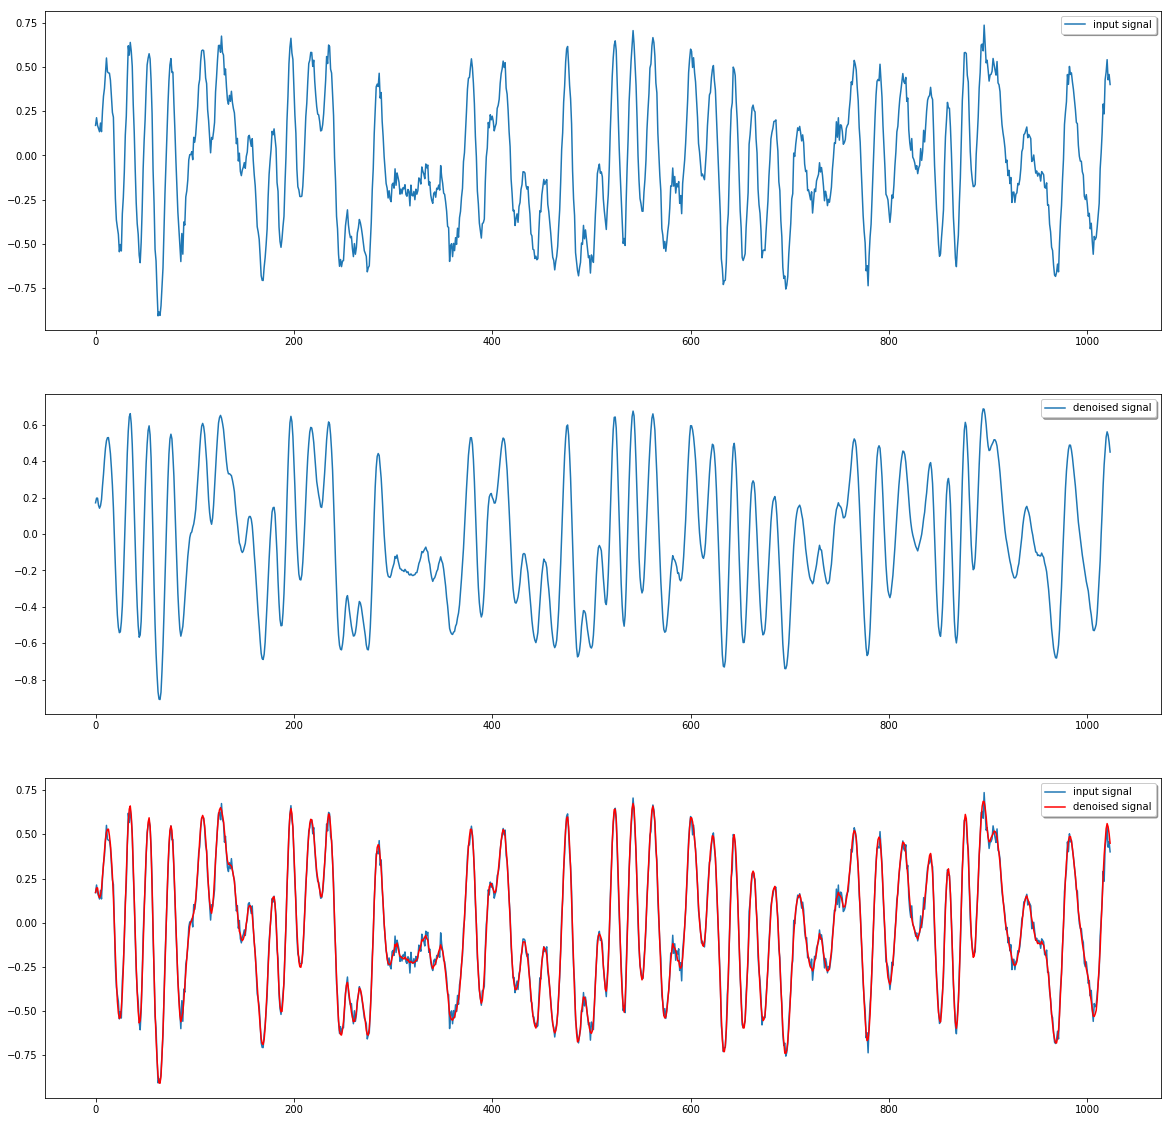

In [8]:
m = 2
plt.figure(4)
fig, ax = plt.subplots(3,1)
fig.set_size_inches(20,20)
ax[0].plot(X_val[m][0], label="input signal")
legend = ax[0].legend(loc=1, shadow=True)
ax[1].plot(X_val_denoised[m][0], label="denoised signal")
legend = ax[1].legend(loc=1, shadow=True)
ax[2].plot(X_val[m][0], label="input signal")
ax[2].plot(X_val_denoised[m][0],color='r', label="denoised signal")
legend = ax[2].legend(loc=1, shadow=True)

In [10]:
Y_val = np.load('.\\dataset\\temp_data\\Y_val.npy')
sp_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              metrics=['accuracy'])
history = sp_model.fit(X_train_denoised, Y_train,
                  epochs=50,
                  batch_size=64,
                  verbose=1,
                  shuffle= True,
                  #validation_data=None)
                  validation_data=(X_val_denoised, Y_val),
                  callbacks=[learning_rate_reduction,early_stopping])  

Train on 162000 samples, validate on 18000 samples
Epoch 1/50
162000/162000 [==============================] - 284s - loss: 0.6259 - acc: 0.7253 - val_loss: 0.6290 - val_acc: 0.7163
Epoch 2/50
162000/162000 [==============================] - 282s - loss: 0.3723 - acc: 0.8297 - val_loss: 0.5139 - val_acc: 0.7837
Epoch 3/50
162000/162000 [==============================] - 282s - loss: 0.3130 - acc: 0.8550 - val_loss: 0.4158 - val_acc: 0.8052
Epoch 4/50
162000/162000 [==============================] - 282s - loss: 0.2610 - acc: 0.8822 - val_loss: 0.3941 - val_acc: 0.8176
Epoch 5/50
162000/162000 [==============================] - 282s - loss: 0.2041 - acc: 0.9130 - val_loss: 0.3907 - val_acc: 0.8255
Epoch 6/50
162000/162000 [==============================] - 282s - loss: 0.1480 - acc: 0.9426 - val_loss: 0.4463 - val_acc: 0.8083
Epoch 7/50
162000/162000 [==============================] - 282s - loss: 0.1053 - acc: 0.9610 - val_loss: 0.5618 - val_acc: 0.8096
Epoch 8/50
162000/162000 [======

In [11]:
sp_model.save_weights('.\\res\\Net_weight\\model_weights_simpleclass_denoise.h5')

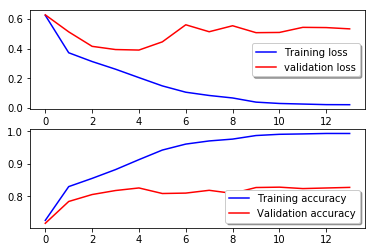

In [12]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

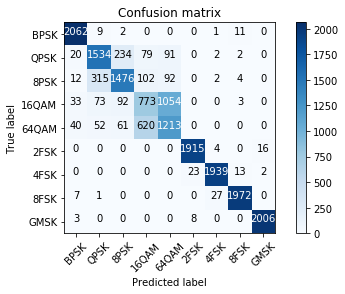

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = sp_model.predict(X_val_denoised)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, normalize=False,classes = classes) 

In [15]:
np.save('.\\dataset\\temp_data\\X_val_denoised.npy',X_val_denoised)
np.save('.\\dataset\\temp_data\\X_train_denoised.npy',X_train_denoised)